## **Problem Statement**

The genuineness of Information has become a long term issue influencing organizations and society, both for printed and computerized media. On interpersonal organizations, the compass and impacts of data spread happen at such a quick pace thus enhanced that mutilated, off base or bogus data procures an enormous potential to cause genuine effects, in practically no time, for many clients.

To provide a solution to this problem, Machine Learning comes in handy. With an historical data that contains information on fake and real news, Machine Learning can be used to classify articles as either fake or not using underlying patterns from the historical data

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split

from wordcloud import WordCloud
from collections import Counter

import re
from nltk.stem import WordNetLemmatizer


import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer as detokenize
from nltk.corpus import stopwords

from textblob import TextBlob

import datetime as dt
import warnings
import string

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# stop_words = []
stop_words = list(set(stopwords.words('english')))
warnings.filterwarnings('ignore')
punctuation = string.punctuation

In [64]:
cachedStopWords = stopwords.words("english")

In [2]:
import flask

In [3]:
# reading in the fake and true news data
fake_data = pd.read_csv("../news-classfier-model/data/archive/Fake.csv")
true_data = pd.read_csv("../news-classfier-model/data/archive/True.csv")

In [4]:
fake_data["label"] = 0
true_data["label"] = 1

In [5]:
fake_data.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [6]:
true_data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [7]:
frames = [fake_data, true_data]
  
data = pd.concat(frames)

In [8]:
data.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [9]:
data.drop(["subject", "date"], axis=1, inplace=True)

In [10]:
df = shuffle(data)
df.reset_index(inplace=True, drop=True)

In [11]:
df.head()

,title,text,label
0,Trump to nominate ex-Army doctor Mark Green as...,WASHINGTON (Reuters) - U.S. President Donald T...,1
1,Schumer Goes ALL IN On ‘Incompetent’ Trump Wh...,The Republican Party and the Trump White House...,0
2,"Biden warns Ukraine on reforms, says EU sancti...",(Reuters) - U.S. Vice President Joe Biden on W...,1
3,U.S. must ensure migration crisis in Europe is...,WASHINGTON (Reuters) - U.S. President Barack O...,1
4,AWESOME! WATCH REPUBLICAN STUDENTS Protest Awa...,"In a rare move, a throng of Republican student...",0


In [12]:
df.to_json("src/data.json", orient="records")

In [13]:
df.isnull().sum()

title    0
text     0
label    0
dtype: int64

## **Data PreProcessing**

Data preprocessing can refer to manipulation or dropping of data before it is used in order to ensure or enhance performance, and is an important step in the data mining process. The phrase "garbage in, garbage out" is particularly applicable to data mining and machine learning projects.

Further readings: https://towardsdatascience.com/data-preprocessing-concepts-fa946d11c825?gi=ca2b14713451, https://www.geeksforgeeks.org/data-preprocessing-in-data-mining/

Extracting some features from the title and news content
The news title and content contains some information that may be important in understaing the pattern undelying in fake or real articles. some of the information that could be extracted includes the length of the title and article, the number of words, the number of part of speech in each article content, etc. Hence we will extract these features and use them in the future to provide a model

In [68]:
def clean_text(text):
    text = ' '.join([word for word in text.split() if word not in cachedStopWords])
    return re.sub(r'[^\w\s]', '', text.lower())

In [14]:
def text_process(df):
    """
    Extracts some text information from both news title and content
    
    Input: 
        df (dataframe like object): This is a data read in using pandas
    
    Output: 
        df (datafame like object): This is a preprocessed data with some new columns extracted from the
            article title and content
    """
    df["title_len"] = df['title'].apply(len)  # getting the length of the title including space
    df["text_len"] = df['text'].apply(len)  # getting the length of the title including space
    df['char_count'] = df['text'].apply(len)
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))  # counting the words in text excluding spaces
    df['word_density'] = df['char_count'] / (df['word_count']+1)  # average length of word used in each text
    df['punctuation_count'] = df['text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 
    df['title_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))  #total number of proper case (title) words in the content
    df['upper_case_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()])) # total number of upper count words in the content
    df['stopword_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.lower() in stop_words]))  # total number of stopwords in the content
    
    return df

In [15]:
df = text_process(df)

In [69]:
df["text"] = df["text"].apply(lambda row: clean_text(row))

In [16]:
def count_part_of_speech(text, pos):
    """
    This methos checks if first word in sentence is a verb or not

    PARAMETERS 
        text (str): Text to be processed   
    RETURN
        Returns (bool): a boolean to confirm if first word in sentence is a verb or not
    """
    pos_dic = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
    }

    word_list = nltk.word_tokenize(text)
    count = 0
    pos_tags = nltk.pos_tag(word_list)  #obtaing the pos taggings
    for tag in pos_tags:
        
        #selecting the pos tag of the first item in the sentence
        _, first_tag = tag

        #checking if the first word in the senntece has a pos tagging of VERB
        if first_tag in pos_dic[pos]:
            count += 1
    return count

In [74]:
def reduce_text(text, num_sent=4):
    """
    This function reduces the volume of the text content by selecting a number of sentence.
    
    Input:
        text (str): the text content which we want to reduce
        num_sent (int): the number of sentence we may want to select
        
    Output:
        text (str): a sample of the text that is be selected
    """
    content = ""
    try:
        tokenized_sentence = sent_tokenize(text)
        reduced_tokenized_sentence = tokenized_sentence[:num_sent]
        content = detokenize().detokenize(reduced_tokenized_sentence)
    except:
        pass
    # content = detokenize().detokenize(sent_tokenize(text)[:num_sent])
    return content

In [75]:
df['reduced_text'] = df['text'].apply(lambda text: reduce_text(text))

In [52]:
def extract_part_of_speech(df, pos):
    """
    This function extracts some part of speech and saves their counts in a columns
    
    Input:
        df (dataframe): The dataframe object
    
    Output:
        df (dataframe): The extended dataframe with the new columns
    """
    col_name = pos + "_count"
    df[col_name] = df['reduced_text'].apply(lambda x: count_part_of_speech(x, pos))
    
    return df

In [51]:
df = extract_part_of_speech(df=df, pos="noun")
df = extract_part_of_speech(df=df, pos="verb")
df = extract_part_of_speech(df=df, pos="adj")
df = extract_part_of_speech(df=df, pos="adv")
df = extract_part_of_speech(df=df, pos="pron")

In [28]:
df.head()

,title,text,label,title_len,text_len,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,stopword_count,reduced_text,noun_count,verb_count,adj_count,adv_count,pron_count
0,Trump to nominate ex-Army doctor Mark Green as...,WASHINGTON (Reuters) - U.S. President Donald T...,1,68,571,571,93,6.074468,14,26,3,32,WASHINGTON (Reuters) - U.S. President Donald T...,41,14,6,3,3
1,Schumer Goes ALL IN On ‘Incompetent’ Trump Wh...,The Republican Party and the Trump White House...,0,83,2377,2377,415,5.713942,45,69,2,191,The Republican Party and the Trump White House...,49,19,6,6,3
2,"Biden warns Ukraine on reforms, says EU sancti...",(Reuters) - U.S. Vice President Joe Biden on W...,1,67,2076,2076,349,5.931429,49,63,3,139,(Reuters) - U.S. Vice President Joe Biden on W...,45,20,5,3,5
3,U.S. must ensure migration crisis in Europe is...,WASHINGTON (Reuters) - U.S. President Barack O...,1,60,495,495,79,6.187500,10,25,2,28,WASHINGTON (Reuters) - U.S. President Barack O...,34,16,5,2,3
4,AWESOME! WATCH REPUBLICAN STUDENTS Protest Awa...,"In a rare move, a throng of Republican student...",0,98,2385,2385,384,6.194805,43,41,6,172,"In a rare move, a throng of Republican student...",65,26,15,6,12


In [29]:
# dropping unused colums

df.drop(['char_count'], axis=1, inplace=True)

## **Data Exploration and Visualization**

Data exploration is an approach similar to initial data analysis, whereby a data analyst uses visual exploration to understand what is in a dataset and the characteristics of the data, rather than through traditional data management systems.

Further reading: https://towardsdatascience.com/on-data-exploration-and-visualisation-ef9f92835bd4

Exploring and visualizing features is one important process of data science. it helps us to examine how the features are distributed.

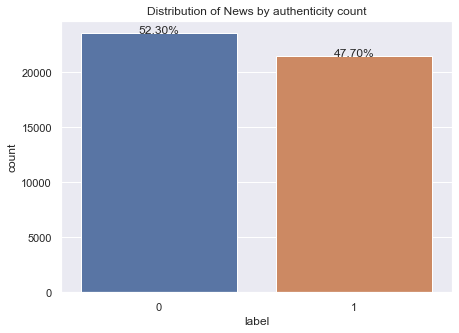

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
ax = sns.countplot(x='label', data=df, ax = axes,);
plt.title("Distribution of News by authenticity count")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/float(len(df))*100)+'%',
            ha="center")
    
plt.savefig('authenticity_count.png', bbox_inches='tight')

As seen above, the label which represents the authenticity of a news as almost evenly distributed. With 52.3% of news being fake and 47.7% of news being authentic, we may conclude that in this study, approximately half of the news population is authentic as well as fake.

### WordCloud
Reading: https://www.analyticsvidhya.com/blog/2020/10/word-cloud-or-tag-cloud-in-python, https://towardsdatascience.com/identify-top-topics-using-word-cloud-9c54bc84d911

This analysis helps us to identify words that were prominent in a news category (fake or authentic). The boldness and size of a word indicates how frequent the word was in that context.

In [81]:
def plot_wordcloud(text, image_name=None):
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    plt.figure(figsize=(12,8))
    plt.imshow(fake_data_word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    word_cloud.to_file(image_name)

In [102]:
fake_data_text = " ".join(title for title in fake_data.text)
true_data_text = " ".join(title for title in true_data.text)

The goal of plotting a word cloud for the fake and authentic news content is to identify which words were prominent among the fake news. The word which occur boldly and big are observed to be the common word

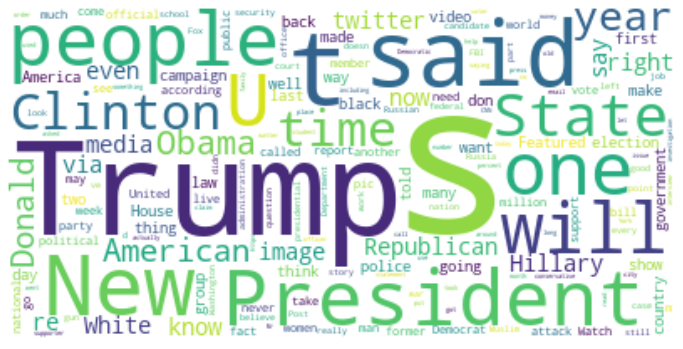

In [103]:
plot_wordcloud(fake_data_text, "fake_wordcloud.png")

From the chart above, it could be observed that The word Trump seems the boldest which indicates that Trump is a common anf frequent word in the whole news content. The word President also seem to occur frequently among others

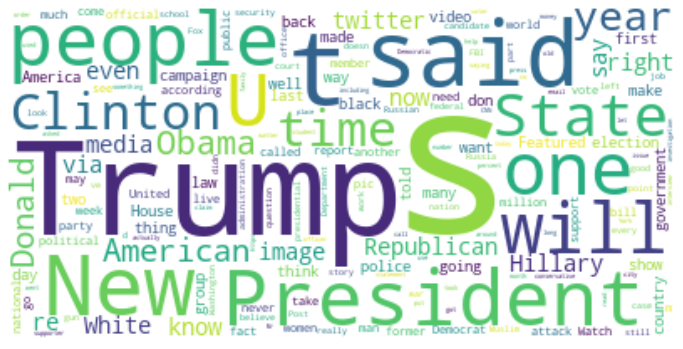

In [104]:
plot_wordcloud(true_data_text, "true_wordcloud.png")

From the chart above, it could be observed that the result from plotting the world cloud for the authentic news content seems identical with the fake nes content. This could be due to underlying reasons beyond the scope of this study.

### Word Frequency

After plotting the word cloud, we would also try to take a look into the top frequent words and how frequent they are. This analysis would be done for both the fake news and the authentic news individually

In [124]:
def plot_top_word_frequency(text, image_name):
    """
    This function plots the top words in the whole news content for each
    category
    """
    fake_data_text = clean_text(text)
    counter = Counter(fake_data_text.split(" "))
    top_words = counter.most_common(10)
    words = dict(top_words).keys()
    counts = dict(top_words).values()
    indexes = np.arange(len(words))
    
    plt.figure(figsize=(12,8))
    width = 0.7
    plt.bar(indexes, counts, width)
    plt.xticks(indexes + width * 0.5, words)
    plt.show();
    plt.savefig(image_name, bbox_inches='tight')
    
    return top_words

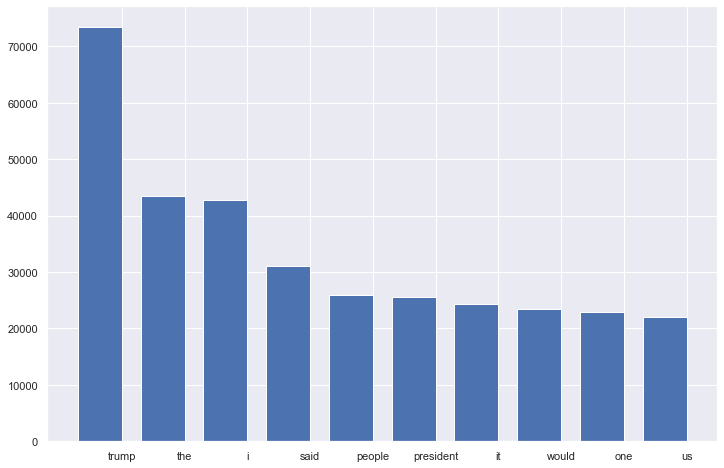

<Figure size 432x288 with 0 Axes>

In [127]:
plot_top_word_frequency(fake_data_text, "fake_word_count.png");

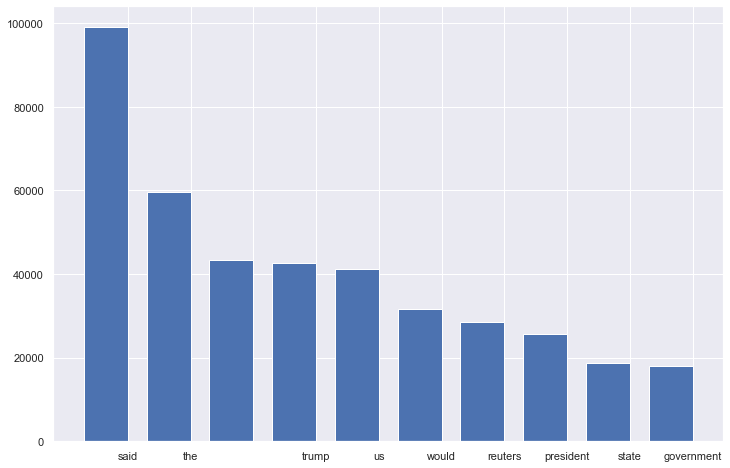

<Figure size 432x288 with 0 Axes>

In [128]:
plot_top_word_frequency(true_data_text, "true_word_count.png");

## What is the relationship of the word counts and upper case count in the news content

The below analysis would help take a look into some of the features derived from the news content. The analysis below takes a look into the linear relationship between the word count in a news content and the upper case word count. 

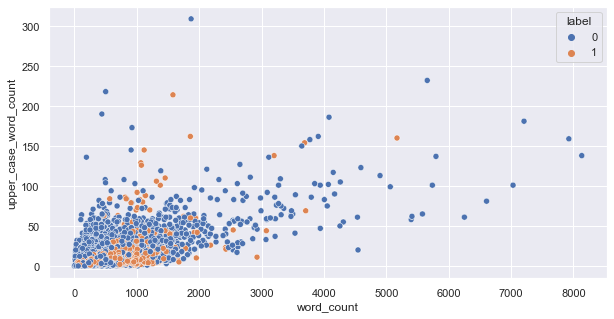

In [129]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
sns.scatterplot(x='word_count', y='upper_case_word_count', data=df, hue='label');
plt.savefig("word_count_versus_upper_case_count.png", bbox_inches='tight')

From the above chart which shows that there is a linear relationship between the word count of the news content and the upper case word count. 

## What is the correlation of punctuation counts and title case count in the text content

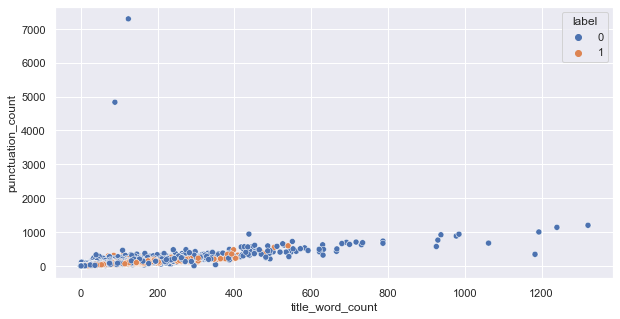

In [130]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
sns.scatterplot(x='title_word_count', y='punctuation_count', data=df, hue='label', );
plt.savefig("punctuation_count_versus_title_case_count.png", bbox_inches='tight')

## what is the relationship of the word counts and stopword count in the text content.

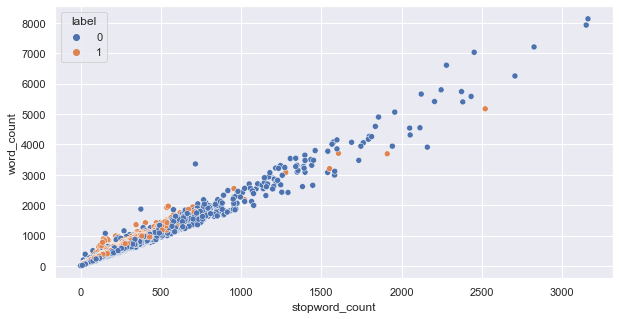

In [131]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
sns.scatterplot(x='stopword_count', y='word_count', data=df, hue='label')
plt.savefig("word_count_versus_stopword_count.png", bbox_inches='tight')

## What is the relationship of the numeric features

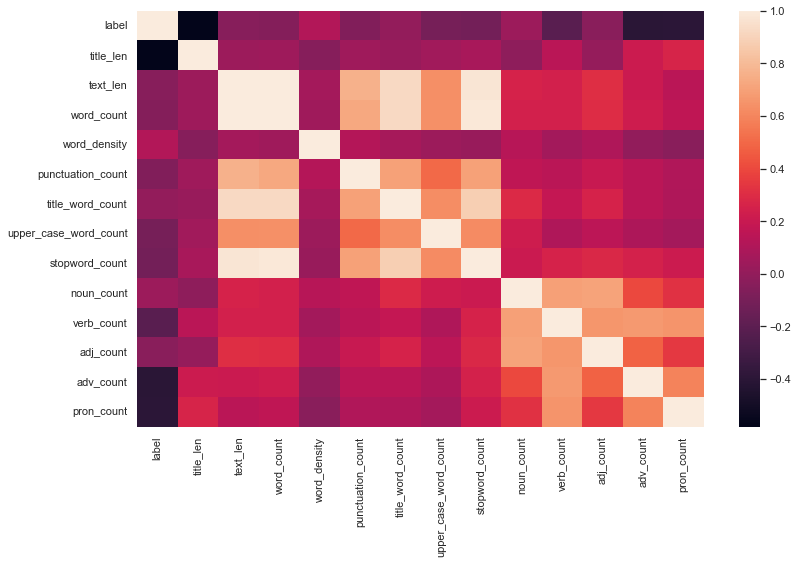

In [132]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr())
plt.tight_layout()
plt.savefig("heatmap_of_extracted_features.png", bbox_inches='tight')

## **Model Training**

Model training is the phase in the data science and machine learning lifecycle where we try to fit the best combination of weights and bias to a machine learning algorithm to minimize a loss function over the prediction range. This phase could also be seen as the phase where we learn the underlying pattern in our data and using the pattern to predict outcomes.

#### Model training consist of two major parts

1. Supervised learning: Supervised learning is the machine learning task of learning a function that maps an input to an output based on example input-output pairs. https://www.techtarget.com/searchenterpriseai/definition/supervised-learning, https://www.sciencedirect.com/topics/computer-science/supervised-learning
2. Unsupervised learning: Unsupervised learning is a type of machine learning in which the algorithm is not provided with any pre-assigned labels or scores for the training data. As a result, unsupervised learning algorithms must first self-discover any naturally occurring patterns in that training data set. https://www.techtarget.com/searchenterpriseai/definition/unsupervised-learning, https://www.ibm.com/cloud/learn/unsupervised-learning

#### For more reading: 
1. https://machinelearningmastery.com/supervised-and-unsupervised-machine-learning-algorithms/
2. https://www.geeksforgeeks.org/supervised-unsupervised-learning/

#### Supervised Learning Models
https://www.analyticsvidhya.com/blog/2017/09/common-machine-learning-algorithms/
https://www.simplilearn.com/10-algorithms-machine-learning-engineers-need-to-know-article

The models that would be used in this study were selected for the following reasons

1. four models were selected due to available computing resources
2. Logistic Regression Model, Support Vector Classifier, Decision Tree Classifier and K Nearest Neighbour were selected because they are used for classification problems like the problem we are trying to solve with this study.

# building a model for the textual features

In [133]:
def tokenize(text):
    '''
    PARAMETERS 
        text (str): Text to be processed   
    RETURN
        Returns a processed text variable that was tokenized, lower cased, stripped, and lemmatized
    '''
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [134]:
# selecting the target feature
y = df['label']

In [135]:
models = [('lr', LogisticRegression()), ('knn', KNeighborsClassifier()), ('cart', DecisionTreeClassifier()), ('svm', LinearSVC())]

In [136]:
def build_nlp_model(X, y, model):
    """
    This function build trains a model using NLP pipeline
    
    Input:
        X (matrix, dataframe): This is the feature(s) which we want to use to fit a model
        Y (series): This is the target feature that we want to predict
    
    Output:
        y_test (series): a subset of the target variable that will be used to evaluate the model
        y_pred (series): the predicted y using the trained model
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
    vect = CountVectorizer(tokenizer=tokenize)
    tfidf = TfidfTransformer()
    clf = model

    # train classifier
    X_train_counts = vect.fit_transform(X_train)
    X_train_tfidf = tfidf.fit_transform(X_train_counts)
    clf.fit(X_train_tfidf, y_train)

    # predict on test data
    X_test_counts = vect.transform(X_test)
    X_test_tfidf = tfidf.transform(X_test_counts)
    y_test_pred = clf.predict(X_test_tfidf)
    y_train_pred = clf.predict(X_train_tfidf)
    
    return y_train, y_train_pred, y_test, y_test_pred

# Model Evaluation and Validation
What is Model Evaluation? Model Evaluation is the process through which we quantify the quality of a model's predictions. To do this, we measure the newly trained model performance on a new and independent dataset. This model will compare labeled data with it's own predictions.

Readings: https://www.jeremyjordan.me/evaluating-a-machine-learning-model/, https://www.analyticsvidhya.com/blog/2021/05/machine-learning-model-evaluation/, 

Overfitting vs Underfitting
1. Overfitting: Good performance on the training data, poor generliazation to other data. 
2. Underfitting: Poor performance on the training data and poor generalization to other data.

Readings: https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/
In order to evaluate the accuracy of the model, model accuracy score from the sklearn package was used. The evaluation metrics was used to choose which learning model classifier best fit the data.

In [143]:
def evaluate_model(model_names, accuracy_dict, f1scores_dict, image_name):
    """
    This function pots the accuracy and f1scores of the models
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))
    fig.suptitle('Model algorithms and their performance')
    ax1.plot(model_names, accuracy_dict["train"])
    ax1.set_title("accuracy comparison of train data")
    ax2.plot(model_names, f1scores_dict["train"], 'tab:orange')
    ax2.set_title("f1scores comparison of train data")
    ax3.plot(model_names, accuracy_dict["test"], 'tab:green')
    ax3.set_title("accuracy comparison of test data")
    ax4.plot(model_names, f1scores_dict["test"], 'tab:red')
    ax4.set_title("f1scores comparison of train data")

    for ax in fig.get_axes():
        ax.label_outer()
    plt.savefig(image_name, bbox_inches='tight')

In [144]:
def train_model (X, y, models, clf, image_name):
        
    """
    This function trains various and evaluates them to observe the best model
    
    Input:
        X (matrix, dataframe): the input features
        y (series): the target feature
        models: a dictionary of models that will be trained
    
    """
    accuracy = {
        "train": {},
        "test": {}
    }
    f1score = {
        "train": {},
        "test": {}
    }
    for i in range(len(models)):
        model = models[i]

        y_train, y_train_pred, y_test_text, y_pred_text = clf(X, y, model[1])
        accuracy["train"][model[0]] = accuracy_score(y_train, y_train_pred)
        accuracy["test"][model[0]] = accuracy_score(y_test_text, y_pred_text)
        f1score["train"][model[0]] = f1_score(y_train, y_train_pred)
        f1score["test"][model[0]] = f1_score(y_test_text, y_pred_text)
    
    model_names = list(f1score["train"].keys())
    f1scores_train = list(f1score["train"].values())
    f1scores_test = list(f1score["test"].values())
    accuracy_train = list(accuracy["train"].values())
    accuracy_test = list(accuracy["test"].values())
    accuracy_dict = {
        "train": accuracy_train,
        "test": accuracy_test
    }
    f1scores_dict = {
        "train": f1scores_train,
        "test": f1scores_test
    }
    evaluate_model(model_names, accuracy_dict, f1scores_dict, image_name)

## Using the reduced text to train a model

For this section of model training, we'd be using the the reduced verison of the news content to train our models. The purpose of training our models using the reduced verison of the news content is to check if we can identify the authenticity of a news by just getting the first few sentences. As opined above, the different model types we'd be considering in this section would be the Logistic Regression Model, Support Vector Classifier, Decision Tree Classifier and K Nearest Neighbour. We'd then evaluate the trained models using accuracy and F1-score from the sklearn package. The best model from this set of models would them be selected as the best in the context of using the reduced verison of the news content.

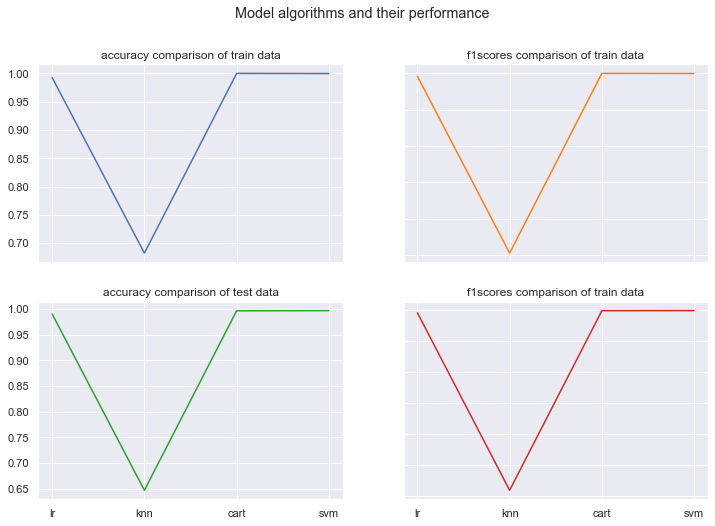

In [147]:
X_text = df['reduced_text']
train_model(X_text, y, models, build_nlp_model, "reduced_text.png")

The plot above evaluates the trained models using our reduced news content. The models that were traines includes; logistic regression, k nearest neighbour, Decision tree classifier and Support vector classifier. As seen in the plot above, Logistic regression, Decision Tree and Support Vector Classifier all fit perectly well to the data with an Accuracy score of 1.0 for the three model. Looking at the performance of the model on the test data, it could be seen that the model performed exactly the same as it did with the training data. Since the train and test F1-score are the same, we may conclude that there is no overfitting when we used logistic regression, k nearest neighbour, Decision tree classifier and Support vector classifier to train our models

Due to the tie in performance of logistic regression, k nearest neighbour, Decision tree classifier and Support vector classifier to the train and test samples, we subjectively select Support vector classifier as the best algorithm for traing a model to the reduced news content

## Using the title to train a model

For this section of model training, we'd be using the news title to train our models. The purpose of training our models using the title is to check if we can identify the authenticity of a news by just getting it's title. As opined above, the different model types we'd be considering in this section would be the Logistic Regression Model, Support Vector Classifier, Decision Tree Classifier and K Nearest Neighbour. We'd then evaluate the trained models using accuracy and F1-score from the sklearn package. The best model from this set of models would them be selected as the best in the context of using the news title.

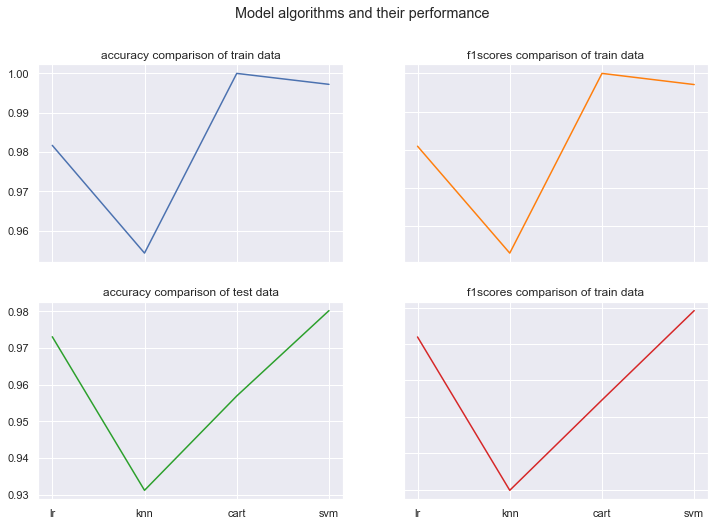

In [149]:
X_title = df['title']
train_model(X_title, y, models, build_nlp_model, "title_model.png")

The plot above evaluates the trained models using our news title. The models that were trained includes; logistic regression, k nearest neighbour, Decision tree classifier and Support vector classifier. As seen in the plot above, Logistic regression, Decision Tree and Support Vector Classifier all fit perectly well to the data with an Accuracy and  F1 score greater than 90% for the four models. Looking at the performance of the model on the test data, it could be seen that the model performed exactly the same as it did with the training data. Since the train and test F1-score are the closely the smae, we may conclude that there is no overfitting or undefritting for all our trained models. 

However we would select Support Vector Classifier as our best model for this round. This is because, though all the trained models perform excellently well, Support Vecor Classifier performed the best in terms of train and test samples.

## Using the full text to train the model

For this section of model training, we'd be using the full news content to train our models. The purpose of training our models using the full news content is to check how the full context of the news influence it's authenticity. As found above, the different model types we'd be considering would be the Logistic Regression Model, Support Vector Classifier, Decision Tree Classifier and K Nearest Neighbour. We'd then evaluate the trained models using accuracy and F1-score from the sklearn package. The best model from this set of models would them be selected as the best in the context of using the full news content.

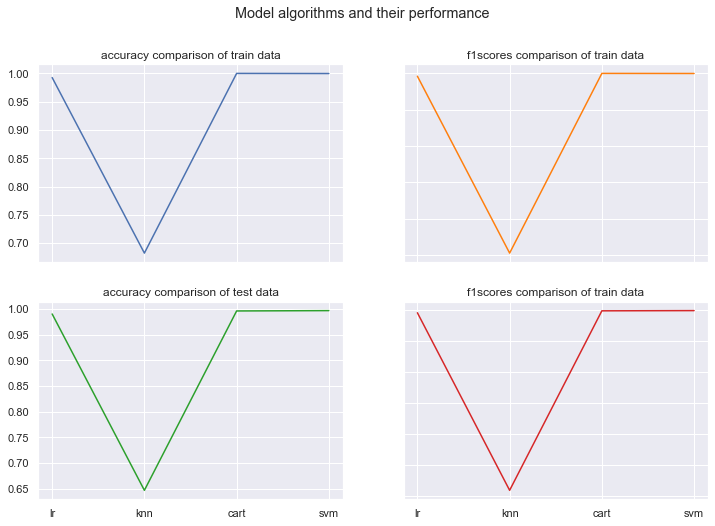

In [150]:
X_text = df['text']
train_model(X_text, y, models, build_nlp_model, "text_model.png")

The plot above evaluates the trained models using our reduced news content. The models that were traines includes; logistic regression, k nearest neighbour, Decision tree classifier and Support vector classifier. As seen in the plot above, Logistic regression, Decision Tree and Support Vector Classifier all fit perectly well to the data with an Accuracy score of 1.0 for the three model. Looking at the performance of the model on the test data, it could be seen that the model performed exactly the same as it did with the training data. Since the train and test F1-score are the same, we may conclude that there is no overfitting when we used logistic regression, k nearest neighbour, Decision tree classifier and Support vector classifier to train our models. 

Furthermore,the performance of the models in this section looks identical to the performance of the models trained using the reduced text. So, it may be assumed that the samples seleced for the reduced text are a very good representation of the full content which may render having models from both sections as redundant. Therefore, the decisions used in the reduced news content model would be used in this case as well

In [49]:
def build_model(X, y, model):
    """
    This function build trains a model using extracted features
    
    Input:
        X (matrix, dataframe): This is the feature(s) which we want to use to fit a model
        Y (series): This is the target feature that we want to predict
    
    Output:
        y_test (series): a subset of the target variable that will be used to evaluate the model
        y_pred (series): the predicted y using the trained model
    """
    
    scaler = StandardScaler()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = model
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    return y_train, y_train_pred, y_test, y_test_pred

## Using the extracted features

For this section of model training, we'd be using the features extracted from the news content to train our models. The features used includes
1. length of the title including space
2. getting the length of the title including space
3. count of words in text excluding spaces
4. average length of word used in each text
5. count of punctuations in the text
6. total number of proper case (title) words in the content
7. total number of upper count words in the content
6. total number of stopwords in the content
8. count of noun in the content
10. count of verb in the content
11. count of adjective in the content
12. count of adverb in the content
13. count of pronount in the content

The goal of these models is to check if these features influence the authenticity of a news in any way and if the influence is significant.

In [47]:
df.head()

,title,text,label,title_len,text_len,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count,stopword_count,reduced_text,noun_count,verb_count,adj_count,adv_count,pron_count
0,Trump to nominate ex-Army doctor Mark Green as...,WASHINGTON (Reuters) - U.S. President Donald T...,1,68,571,93,6.074468,14,26,3,32,WASHINGTON (Reuters) - U.S. President Donald T...,41,14,6,3,3
1,Schumer Goes ALL IN On ‘Incompetent’ Trump Wh...,The Republican Party and the Trump White House...,0,83,2377,415,5.713942,45,69,2,191,The Republican Party and the Trump White House...,49,19,6,6,3
2,"Biden warns Ukraine on reforms, says EU sancti...",(Reuters) - U.S. Vice President Joe Biden on W...,1,67,2076,349,5.931429,49,63,3,139,(Reuters) - U.S. Vice President Joe Biden on W...,45,20,5,3,5
3,U.S. must ensure migration crisis in Europe is...,WASHINGTON (Reuters) - U.S. President Barack O...,1,60,495,79,6.187500,10,25,2,28,WASHINGTON (Reuters) - U.S. President Barack O...,34,16,5,2,3
4,AWESOME! WATCH REPUBLICAN STUDENTS Protest Awa...,"In a rare move, a throng of Republican student...",0,98,2385,384,6.194805,43,41,6,172,"In a rare move, a throng of Republican student...",65,26,15,6,12


In [43]:
X = df.drop(['title', 'label', 'reduced_text', 'text'], axis=1)

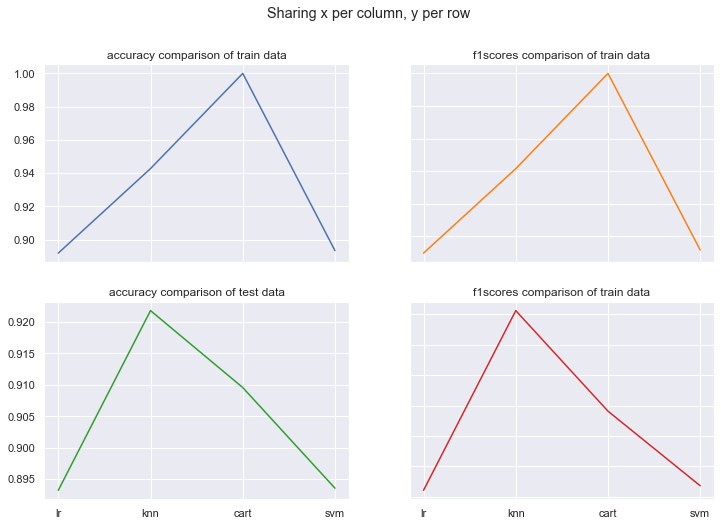

In [142]:
train_model(X, y, models, build_model, "extracted_features.png")

The plot above evaluates the trained models using our extracted features including part of speech counts, word counts, etc. The models that were trained includes; logistic regression, k nearest neighbour, Decision tree classifier and Support vector classifier. As seen in the plot above, Logistic regression, K Nearest Neighbour, Decision Tree and Support Vector Classifier all fit excellently well to the data with an Accuracy and F1 score greater than 90% for the four models. Looking at the performance of the model on the test data, it could be seen that there is an overfitting of the model using Decision Tree Classifier since it's accuracy on the train data records 100% and the test data records about 90%, translating to 10% deficit. Also, Overfitting was recorded for the K Nearest Neighbout algorithm. 

The chart above showed that the performance of the Logistic regression and the Support Vector Classifier were similar, no overfitting or undefitting, so we'd select the best algorithm subjectively. Therefore, since SVC has been the best algorithm for training a model to all other features, we'd select SVC as the best model in this case as well

## **Summary**

For this study, four different machine learning algorithm were selected. The algoritms includes; Logistic regression, K Nearest N;leighbour, Decision Tree and Support Vector Classifier. They were selected because they solve classification ploblems and our study has a classification problem. The algorithms were used to train models to the following features; news title, news reduced content, news full content and extracted features from news content. performance of each algorithm on the above features and the following result were derived
1. Title model: Support Vector Classifier was selected as the best algorithm for training a model using the news title because it performed the best in terms of train and test samples .

2. Reduced content model: Support Vector Classifier was selected as the best algorithm for training a model using the reduced news content.

3. full content model: Support Vector Classifier was selected as the best algorithm for training a model using the full news content because it has same performance and similar feature with the reduce content model.

4. Extracted features model. Support vector classifier was selcted as the best algorithm for training a model using the extracted features. This algorithm was selected because it has good accuracy and didnt experience overfitting or underfitting